In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 104)
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

%matplotlib inline

# Data Cleaning & Transformation

In [2]:
# import dataset with every UFC fight from 3/10/1994 to 3/19/2021
df_match = pd.read_csv('data.csv')
df_match.head(3)

,R_fighter,B_fighter,Referee,date,location,Winner,title_bout,weight_class,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_avg_TD_att,B_avg_TD_landed,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_BODY_att,B_avg_BODY_landed,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_LEG_att,B_avg_LEG_landed,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_GROUND_att,B_avg_GROUND_landed,...,R_avg_opp_TOTAL_STR_landed,R_avg_TD_att,R_avg_TD_landed,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_BODY_att,R_avg_BODY_landed,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_LEG_att,R_avg_LEG_landed,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_total_time_fought(seconds),R_total_rounds_fought,R_total_title_bouts,R_current_win_streak,R_current_lose_streak,R_longest_win_streak,R_wins,R_losses,R_draw,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Stance,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
0,Adrian Yanez,Gustavo Lopez,Chris Tognoni,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Bantamweight,0.0,0.0,0.42,0.495,0.33,0.36,0.5,1.0,0.0,0.0,50.0,20.0,84.0,45.0,76.5,41.0,114.0,64.0,1.5,1.0,9.0,6.5,39.5,11.0,63.0,27.5,7.5,7.0,12.0,9.0,3.0,2.0,9.0,8.5,35.0,12.5,43.5,17.5,10.5,4.5,4.0,3.0,4.5,3.0,...,9.00000,0.00000,0.00000,3.00000,0.0000,32.00000,15.00000,11.000000,5.00000,2.00000,2.000000,2.00000,1.00000,0.000000,0.000000,0.000000,0.000000,33.0000,16.00000,12.00000,6.0000,1.000000,1.00000,1.0000,0.000000,0.00000,0.00000,0.00000,0.00000,5.000000,54.00000,166.000000,1,0,1,0,1,1,0,0,0,0,0,1,0,0,Orthodox,170.18,177.80,135.0,31.0,27.0
1,Trevin Giles,Roman Dolidze,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Middleweight,0.5,0.0,0.66,0.305,0.30,0.50,1.5,0.0,0.0,0.0,65.5,35.0,50.0,16.5,113.5,68.5,68.5,29.0,2.5,1.5,0.5,0.5,46.0,20.0,36.0,7.5,12.0,8.0,8.0,3.0,7.5,7.0,6.0,6.0,58.0,30.0,48.0,15.5,0.5,0.5,0.5,0.5,7.0,4.5,...,52.46875,1.28125,0.78125,4.68750,0.4375,71.09375,38.06250,50.406250,13.34375,4.68750,3.312500,9.09375,6.15625,1.781250,1.781250,9.656250,8.093750,58.3125,30.43750,63.31250,23.1250,6.968750,3.65625,5.0000,4.125000,12.28125,9.06250,0.84375,0.34375,176.156250,154.68750,747.343750,17,0,2,0,2,4,2,0,0,1,0,3,0,0,Orthodox,182.88,187.96,185.0,32.0,28.0
2,Tai Tuivasa,Harry Hunsucker,Herb Dean,2021-03-20,"Las Vegas, Nevada, USA",Red,False,Heavyweight,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.90625,0.03125,0.00000,2.84375,1.7500,42.50000,16.78125,34.296875,17.93750,5.78125,4.546875,6.12500,3.71875,10.953125,9.046875,3.390625,3.140625,45.8750,20.28125,36.34375,18.6875,11.328125,8.56250,1.4375,1.171875,2.03125,1.53125,6.03125,4.93750,82.453125,89.78125,448.203125,13,0,3,0,3,4,3,0,0,0,1,3,0,0,Southpaw,187.96,190.50,264.0,32.0,28.0


In [3]:
# import dataset with stats of every fighter since UFC's genesis
df_fighter = pd.read_csv('raw_fighter_details.csv')
df_fighter.head(3)

,fighter_name,Height,Weight,Reach,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Tom Aaron,NaN,155 lbs.,NaN,NaN,"Jul 13, 1978",0.00,0%,0.00,0%,0.00,0%,0%,0.0
1,Papy Abedi,"5' 11""",185 lbs.,NaN,Southpaw,"Jun 30, 1978",2.80,55%,3.15,48%,3.47,57%,50%,1.3
2,Shamil Abdurakhimov,"6' 3""",235 lbs.,"76""",Orthodox,"Sep 02, 1981",2.45,44%,2.45,58%,1.23,24%,47%,0.2


In [4]:
# have 'Winner' column display fighter's name instead of corner color
df_match.loc[(df_match.Winner == 'Red'),'Winner']= df_match.R_fighter
df_match.loc[(df_match.Winner == 'Blue'),'Winner']= df_match.B_fighter

In [5]:
# separate Red and Blue corners so that each row represents one observation
df_blue = df_match[df_match.columns[0:75]]
df_blue['B_age'] = df_match['B_age']
df_blue = df_blue.drop(['R_fighter', 'weight_class', 'title_bout', 'Referee', 'date', 'location', 'B_Stance'], 1)

red_columns = df_match.columns[0:6]
red_columns = red_columns.append(df_match.columns[75:])
df_red = df_match[red_columns]
df_red = df_red.drop(['B_fighter', 'Referee', 'date', 'location', 'B_age', 'R_Stance'], 1)

In [6]:
# display only winners for each corner to delete duplicated results
df_red = df_red.loc[df_red['Winner'] == df_red['R_fighter']]
df_blue = df_blue.loc[df_blue['Winner'] == df_blue['B_fighter']]

In [7]:
df_red.head(3)

,R_fighter,Winner,R_avg_KD,R_avg_opp_KD,R_avg_SIG_STR_pct,R_avg_opp_SIG_STR_pct,R_avg_TD_pct,R_avg_opp_TD_pct,R_avg_SUB_ATT,R_avg_opp_SUB_ATT,R_avg_REV,R_avg_opp_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_avg_TD_att,R_avg_TD_landed,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_BODY_att,R_avg_BODY_landed,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_LEG_att,R_avg_LEG_landed,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_total_time_fought(seconds),R_total_rounds_fought,R_total_title_bouts,R_current_win_streak,R_current_lose_streak,R_longest_win_streak,R_wins,R_losses,R_draw,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Height_cms,R_Reach_cms,R_Weight_lbs,R_age
0,Adrian Yanez,Adrian Yanez,1.000000,0.0000,0.500000,0.460000,0.00000,0.00000,0.00,0.0000,0.000,0.00,34.000000,17.00000,13.00000,6.000000,35.000,18.000000,16.000000,9.00000,0.00000,0.00000,3.00000,0.0000,32.00000,15.00000,11.000000,5.00000,2.00000,2.000000,2.00000,1.00000,0.000000,0.000000,0.000000,0.000000,33.0000,16.00000,12.00000,6.0000,1.000000,1.00000,1.0000,0.000000,0.00000,0.00000,0.00000,0.00000,5.000000,54.00000,166.000000,1,0,1,0,1,1,0,0,0,0,0,1,0,0,170.18,177.80,135.0,27.0
1,Trevin Giles,Trevin Giles,1.031250,0.0625,0.576875,0.381250,0.40625,0.11625,0.25,1.1875,0.375,0.25,77.562500,43.15625,69.15625,27.593750,93.125,57.218750,98.343750,52.46875,1.28125,0.78125,4.68750,0.4375,71.09375,38.06250,50.406250,13.34375,4.68750,3.312500,9.09375,6.15625,1.781250,1.781250,9.656250,8.093750,58.3125,30.43750,63.31250,23.1250,6.968750,3.65625,5.0000,4.125000,12.28125,9.06250,0.84375,0.34375,176.156250,154.68750,747.343750,17,0,2,0,2,4,2,0,0,1,0,3,0,0,182.88,187.96,185.0,28.0
2,Tai Tuivasa,Tai Tuivasa,0.546875,0.1875,0.538906,0.598594,0.00000,0.31250,0.00,0.2500,0.000,0.00,59.234375,30.37500,43.81250,24.796875,70.500,41.390625,50.234375,30.90625,0.03125,0.00000,2.84375,1.7500,42.50000,16.78125,34.296875,17.93750,5.78125,4.546875,6.12500,3.71875,10.953125,9.046875,3.390625,3.140625,45.8750,20.28125,36.34375,18.6875,11.328125,8.56250,1.4375,1.171875,2.03125,1.53125,6.03125,4.93750,82.453125,89.78125,448.203125,13,0,3,0,3,4,3,0,0,0,1,3,0,0,187.96,190.50,264.0,28.0


In [8]:
df_blue.head(3)

,B_fighter,Winner,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_avg_TD_att,B_avg_TD_landed,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_BODY_att,B_avg_BODY_landed,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_LEG_att,B_avg_LEG_landed,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_CTRL_time(seconds),B_avg_opp_CTRL_time(seconds),B_total_time_fought(seconds),B_total_rounds_fought,B_total_title_bouts,B_current_win_streak,B_current_lose_streak,B_longest_win_streak,B_wins,B_losses,B_draw,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,B_Height_cms,B_Reach_cms,B_Weight_lbs,B_age
3,Montserrat Conejo,Montserrat Conejo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152.40,154.94,115.0,28.0
4,Macy Chiasson,Macy Chiasson,0.125,0.0,0.535625,0.57875,0.185,0.16625,0.125,0.1875,0.25,0.00,109.1875,57.9375,50.625,28.4375,170.4375,105.625,74.375,44.25,5.375,1.500,2.00,0.625,77.375,31.375,41.5625,22.625,31.1875,26.1875,7.6875,4.9375,0.625,0.375,1.375,0.875,33.5625,11.000,32.0625,13.9375,39.0625,28.8125,13.3125,10.75,36.5625,18.125,5.250,3.750,390.25,156.3125,764.000,11,1,3,0,3,4,1,0,0,0,1,2,1,0,180.34,182.88,135.0,29.0
5,Grant Dawson,Grant Dawson,0.000,0.0,0.515000,0.47375,0.435,0.25000,1.250,0.6250,0.00,0.25,86.0000,40.7500,55.500,25.1250,150.6250,93.500,79.000,46.75,6.375,2.625,0.25,0.250,60.625,23.125,42.3750,14.625,10.0000,4.5000,10.6250,8.2500,15.375,13.125,2.500,2.250,68.8750,29.625,50.1250,20.2500,3.1250,2.0000,3.0000,2.75,14.0000,9.125,2.375,2.125,431.75,17.3750,717.875,10,0,4,0,4,4,0,0,0,0,2,0,2,0,177.80,182.88,145.0,27.0


In [9]:
df_red.columns = df_red.columns.str.strip('R_')
df_blue.columns = df_blue.columns.str.strip('B_')

In [10]:
# combine observations and fill in infinity values with mean
frames = [df_red, df_blue]
df_stats = pd.concat(frames).reset_index(drop=True)
df_stats[df_stats==np.inf]=np.nan
df_stats.fillna(df_stats.mean(), inplace=True)

In [11]:
df_stats.head(3)

,fighter,Winner,avg_KD,avg_opp_KD,avg_SIG_STR_pct,avg_opp_SIG_STR_pct,avg_TD_pct,avg_opp_TD_pct,avg_SUB_ATT,avg_opp_SUB_ATT,avg_REV,avg_opp_REV,avg_SIG_STR_att,avg_SIG_STR_landed,avg_opp_SIG_STR_att,avg_opp_SIG_STR_landed,avg_TOTAL_STR_att,avg_TOTAL_STR_landed,avg_opp_TOTAL_STR_att,avg_opp_TOTAL_STR_landed,avg_TD_att,avg_TD_landed,avg_opp_TD_att,avg_opp_TD_landed,avg_HEAD_att,avg_HEAD_landed,avg_opp_HEAD_att,avg_opp_HEAD_landed,avg_BODY_att,avg_BODY_landed,avg_opp_BODY_att,avg_opp_BODY_landed,avg_LEG_att,avg_LEG_landed,avg_opp_LEG_att,avg_opp_LEG_landed,avg_DISTANCE_att,avg_DISTANCE_landed,avg_opp_DISTANCE_att,avg_opp_DISTANCE_landed,avg_CLINCH_att,avg_CLINCH_landed,avg_opp_CLINCH_att,avg_opp_CLINCH_landed,avg_GROUND_att,avg_GROUND_landed,avg_opp_GROUND_att,avg_opp_GROUND_landed,avg_CTRL_time(seconds),avg_opp_CTRL_time(seconds),total_time_fought(seconds),total_rounds_fought,total_title_bouts,current_win_streak,current_lose_streak,longest_win_streak,wins,losses,draw,win_by_Decision_Majority,win_by_Decision_Split,win_by_Decision_Unanimous,win_by_KO/TKO,win_by_Submission,win_by_TKO_Doctor_Stoppage,Height_cms,each_cms,Weight_lbs,age,Reach_cms
0,Adrian Yanez,Adrian Yanez,1.000000,0.0000,0.500000,0.460000,0.00000,0.00000,0.00,0.0000,0.000,0.00,34.000000,17.00000,13.00000,6.000000,35.000,18.000000,16.000000,9.00000,0.00000,0.00000,3.00000,0.0000,32.00000,15.00000,11.000000,5.00000,2.00000,2.000000,2.00000,1.00000,0.000000,0.000000,0.000000,0.000000,33.0000,16.00000,12.00000,6.0000,1.000000,1.00000,1.0000,0.000000,0.00000,0.00000,0.00000,0.00000,5.000000,54.00000,166.000000,1,0,1,0,1,1,0,0,0,0,0,1,0,0,170.18,177.80,135.0,27.0,183.125591
1,Trevin Giles,Trevin Giles,1.031250,0.0625,0.576875,0.381250,0.40625,0.11625,0.25,1.1875,0.375,0.25,77.562500,43.15625,69.15625,27.593750,93.125,57.218750,98.343750,52.46875,1.28125,0.78125,4.68750,0.4375,71.09375,38.06250,50.406250,13.34375,4.68750,3.312500,9.09375,6.15625,1.781250,1.781250,9.656250,8.093750,58.3125,30.43750,63.31250,23.1250,6.968750,3.65625,5.0000,4.125000,12.28125,9.06250,0.84375,0.34375,176.156250,154.68750,747.343750,17,0,2,0,2,4,2,0,0,1,0,3,0,0,182.88,187.96,185.0,28.0,183.125591
2,Tai Tuivasa,Tai Tuivasa,0.546875,0.1875,0.538906,0.598594,0.00000,0.31250,0.00,0.2500,0.000,0.00,59.234375,30.37500,43.81250,24.796875,70.500,41.390625,50.234375,30.90625,0.03125,0.00000,2.84375,1.7500,42.50000,16.78125,34.296875,17.93750,5.78125,4.546875,6.12500,3.71875,10.953125,9.046875,3.390625,3.140625,45.8750,20.28125,36.34375,18.6875,11.328125,8.56250,1.4375,1.171875,2.03125,1.53125,6.03125,4.93750,82.453125,89.78125,448.203125,13,0,3,0,3,4,3,0,0,0,1,3,0,0,187.96,190.50,264.0,28.0,183.125591


In [12]:
# drop 'fighter' column since we can just use 'Winner' column now
df_stats = df_stats.drop(['fighter'], 1)

In [13]:
# stance and reach are basic information that should be recorded for all active or notable fighters. Can drop fighters without those records

df_fighter = df_fighter[df_fighter['Stance'].notna()]
df_fighter = df_fighter[df_fighter['Reach'].notna()].reset_index(drop=True)


In [14]:
# change Height from str to float
height = df_fighter["Height"]

height_list = [
    
]
for i in df_fighter["Height"]:
    New_list = i.split()
    removetable = str.maketrans('', '', '"\'')
    out_list = [s.translate(removetable) for s in New_list]
    Format = int(out_list[0]) * 12
    Format = Format + int(out_list[1])
    height[i] = Format
    height_list.append(Format)

df_fighter["Height"] = height_list
df_fighter['Height'] = df_fighter['Height'].astype(float)

In [15]:
# change Reach from str to float
reach = df_fighter['Reach']
 
for i in range (0 ,len(reach)):    
    x= str(reach[i])
    #Incase lbs is part of observation remove it
    if "\"" in x[-1:]:
        #Remove the lbs from the value
        x = x[:-1:]
        #Convert string to float
        float_x = float(x)
        reach[i]= float_x
        
df_fighter['Reach'] = reach
df_fighter['Reach'] = df_fighter['Reach'].astype(float)

In [16]:
# Removing percentage signs to turn all data numerical
df_fighter['Str_Acc'] = df_fighter['Str_Acc'].str.strip('%').astype(int)
df_fighter['Str_Def'] = df_fighter['Str_Def'].str.strip('%').astype(int)
df_fighter['TD_Acc'] = df_fighter['TD_Acc'].str.strip('%').astype(int)
df_fighter['TD_Def'] = df_fighter['TD_Def'].str.strip('%').astype(int)

# Convert percentages to decimals
df_fighter['Str_Acc'] /= 100
df_fighter['Str_Def'] /= 100
df_fighter['TD_Acc'] /= 100
df_fighter['TD_Def'] /= 100

In [17]:
# Changing Weight from str to float
weight = df_fighter['Weight']
 
for i in range (0 ,len(weight)):    
    x= str(weight[i])
    #Incase lbs is part of observation remove it
    if "lbs." in x[-4:]:
        #Remove the lbs from the value
        x = x[:-4:]
        #Convert string to float
        float_x = float(x)
        weight[i]= float_x
        
df_fighter['Weight'] = weight
df_fighter['Weight'] = df_fighter['Weight'].astype(float)

In [18]:
# Change fighters' birth dates from string to datetime

df_fighter['DOB'] =  pd.to_datetime(df_fighter['DOB'], format='%b %d, %Y')

In [19]:
df_fighter.dtypes

# Check that all columns have been converted to relevant data types for quantitative analysis

fighter_name            object
Height                 float64
Weight                 float64
Reach                  float64
Stance                  object
DOB             datetime64[ns]
SLpM                   float64
Str_Acc                float64
SApM                   float64
Str_Def                float64
TD_Avg                 float64
TD_Acc                 float64
TD_Def                 float64
Sub_Avg                float64
dtype: object

In [20]:
df_fighter.head(3)

,fighter_name,Height,Weight,Reach,Stance,DOB,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Shamil Abdurakhimov,75.0,235.0,76.0,Orthodox,1981-09-02,2.45,0.44,2.45,0.58,1.23,0.24,0.47,0.2
1,Daichi Abe,71.0,170.0,71.0,Orthodox,1991-11-27,3.80,0.33,4.49,0.56,0.33,0.50,0.00,0.0
2,Klidson Abreu,72.0,205.0,74.0,Orthodox,1992-12-24,2.05,0.40,2.90,0.55,0.64,0.20,0.80,0.0


In [21]:
df_results = df_match[['R_fighter', 'B_fighter', 'Winner']]
df_results.head()

,R_fighter,B_fighter,Winner
0,Adrian Yanez,Gustavo Lopez,Adrian Yanez
1,Trevin Giles,Roman Dolidze,Trevin Giles
2,Tai Tuivasa,Harry Hunsucker,Tai Tuivasa
3,Cheyanne Buys,Montserrat Conejo,Montserrat Conejo
4,Marion Reneau,Macy Chiasson,Macy Chiasson


In [22]:
# binary results
df_results["Outcome"] = (df_results["Winner"] == df_results["R_fighter"]).astype("int")
df_results.drop("Winner", axis=1, inplace=True)
df_results['Winner'] = df_results['R_fighter']

In [23]:
df_results

,R_fighter,B_fighter,Outcome,Winner
0,Adrian Yanez,Gustavo Lopez,1,Adrian Yanez
1,Trevin Giles,Roman Dolidze,1,Trevin Giles
2,Tai Tuivasa,Harry Hunsucker,1,Tai Tuivasa
3,Cheyanne Buys,Montserrat Conejo,0,Cheyanne Buys
4,Marion Reneau,Macy Chiasson,0,Marion Reneau
...,...,...,...,...
6007,Remco Pardoel,Alberta Cerra Leon,1,Remco Pardoel
6008,Orlando Wiet,Robert Lucarelli,1,Orlando Wiet
6009,Johnny Rhodes,David Levicki,1,Johnny Rhodes
6010,Patrick Smith,Ray Wizard,1,Patrick Smith


In [24]:
df_fighter_stats = df_fighter[['fighter_name', 'SLpM', 'Str_Acc', 'SApM', 'Str_Def', 'TD_Avg', 'TD_Acc', 'TD_Def', 'Sub_Avg']]

In [25]:
df_fighter_stats['Winner'] = df_fighter_stats['fighter_name']

In [26]:
df_combined = pd.merge(df_results, df_fighter_stats, on='Winner', how='outer')
df_combined = df_combined[df_combined['Outcome'].notna()]
df_combined = df_combined[df_combined['fighter_name'].notna()]
df_combined = df_combined.drop(['R_fighter', 'B_fighter', 'Winner', 'fighter_name'], axis=1)

,R_fighter,B_fighter,Outcome,Winner,fighter_name,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,Adrian Yanez,Gustavo Lopez,1.0,Adrian Yanez,Adrian Yanez,4.69,0.44,2.31,0.55,0.00,0.00,1.00,0.0
1,Adrian Yanez,Victor Rodriguez,1.0,Adrian Yanez,Adrian Yanez,4.69,0.44,2.31,0.55,0.00,0.00,1.00,0.0
2,Trevin Giles,Roman Dolidze,1.0,Trevin Giles,Trevin Giles,3.26,0.56,1.88,0.62,1.37,0.80,0.79,0.3
3,Trevin Giles,Bevon Lewis,1.0,Trevin Giles,Trevin Giles,3.26,0.56,1.88,0.62,1.37,0.80,0.79,0.3
4,Trevin Giles,James Krause,1.0,Trevin Giles,Trevin Giles,3.26,0.56,1.88,0.62,1.37,0.80,0.79,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819,Jens Pulver,John Lewis,1.0,Jens Pulver,Jens Pulver,2.12,0.37,3.13,0.56,0.22,0.33,0.63,0.3
5820,Jens Pulver,Joao Roque,1.0,Jens Pulver,Jens Pulver,2.12,0.37,3.13,0.56,0.22,0.33,0.63,0.3
5821,Jens Pulver,David Velasquez,1.0,Jens Pulver,Jens Pulver,2.12,0.37,3.13,0.56,0.22,0.33,0.63,0.3
5822,Jens Pulver,Alfonso Alcarez,0.0,Jens Pulver,Jens Pulver,2.12,0.37,3.13,0.56,0.22,0.33,0.63,0.3


In [28]:
df_combined.head(3)

,Outcome,SLpM,Str_Acc,SApM,Str_Def,TD_Avg,TD_Acc,TD_Def,Sub_Avg
0,1.0,4.69,0.44,2.31,0.55,0.00,0.0,1.00,0.0
1,1.0,4.69,0.44,2.31,0.55,0.00,0.0,1.00,0.0
2,1.0,3.26,0.56,1.88,0.62,1.37,0.8,0.79,0.3


- SLpM: Significant Strikes Landed per Minute
- Str_Acc: Significant Striking Accuracy
- SApM: Significant Strikes Absorbed per Minute
- Str_Def: Significant Strike Defence (the % of opponents strikes that did not land)
- TD_Avg: Average Takedowns Landed per 15 minutes
- TD_Acc: Takedown Accuracy
- TD_Def: Takedown Defense (the % of opponents TD attempts that did not land)
- Sub_Avg: Average Submissions Attempted per 15 minutes

source: http://ufcstats.com/

# Data Analysis

## EDA

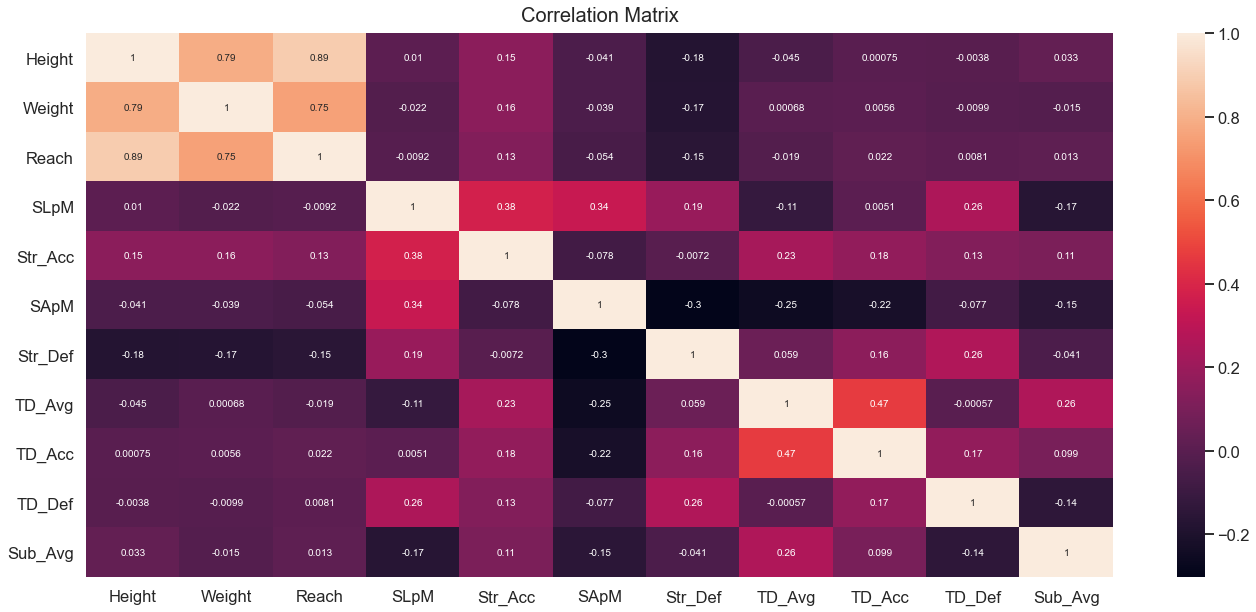

In [32]:
plt.figure(figsize=(23, 10))
heatmap = sns.heatmap(df_fighter.corr(), annot=True)
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':20}, pad=12);

### Data Modeling

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [ ]:
def ranfor(X_train,Y_train,X_test,Y_test,Models):
    randomfor = RandomForestClassifier(max_features="sqrt",
                                       n_estimators = 700,
                                       max_depth = None,
                                       n_jobs=-1
                                      )
    randomfor.fit(X_train,Y_train)
    Y_pred = randomfor.predict(X_test)
    Models['Random Forests'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

In [ ]:
def dec_tree(X_train,Y_train,X_test,Y_test,Models):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, Y_train)
    Y_pred = decision_tree.predict(X_test)
    Models['Decision Tree'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

In [ ]:
def bayes(X_train,Y_train,X_test,Y_test,Models):
    gaussian = GaussianNB()
    gaussian.fit(X_train, Y_train)
    Y_pred = gaussian.predict(X_test)
    Models['Bayes'] = [accuracy_score(Y_test,Y_pred),confusion_matrix(Y_test,Y_pred)]
    return

In [ ]:
def run_all_and_Plot(df):
    Models = dict()
    from sklearn.model_selection import train_test_split
    X_all = df_stats.drop(['Winner'], axis=1)
    y_all = df_stats['Winner']
    X_train, X_test, Y_train, Y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=0)
    ranfor(X_train,Y_train,X_test,Y_test,Models)
    dec_tree(X_train,Y_train,X_test,Y_test,Models)
    bayes(X_train,Y_train,X_test,Y_test,Models)
    return Models

In [ ]:
def plot_bar(dict):
    labels = tuple(dict.keys())
    y_pos = np.arange(len(labels))
    values = [dict[n][0] for n in dict]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels,rotation='vertical')
    plt.ylabel('accuracy')
    plt.title('Accuracy of different models')
    plt.show()

In [ ]:
accuracies = run_all_and_Plot(df_stats)
CompareAll = dict()
CompareAll['Baseline'] = accuracies
for key,val in accuracies.items():
    print(str(key) +' '+ str(val[0]))
plot_bar(accuracies)

In [35]:
# get ready for deep learning
X, y = df_combined.iloc[:, 1:], df_combined.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# normalization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
model = Sequential()

model.add(Dense(16, input_dim=X_train_scaled.shape[1],
                activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [37]:
model.fit(x=X_train_scaled, y=y_train, epochs=200, batch_size=64, verbose=0)
test_results = model.evaluate(x = X_test_scaled, y = y_test, verbose=0)
print("Test Accuracy = {}".format(test_results[1]))

Test Accuracy = 0.6735057830810547


In [77]:
parameters = ['SLpM', 'Str_Acc', 'SApM', 'Str_Def', 'TD_Avg', 'TD_Acc', 'TD_Def', 'Sub_Avg']

In [83]:
# function for predictions
def predict(model, fighter1, fighter2):
    data1 = df_fighter_stats.loc[fighter1, parameters]
    data2 = df_fighter_stats.loc[fighter2, parameters]
    data_diff = (data1 - data2).values.reshape(1, -1)
    data_diff_scaled = scaler.transform(data_diff)
    return model.predict(data_diff_scaled)

print(predict(model, "Conor McGregor", "Khabib Nurmagomedov"))

[[0.40328953]]
